In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import weibull
sys.path.append('../../..')

import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

In [36]:
%matplotlib notebook

In [37]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [38]:
# Loading in the compressed data
Flattenedfilename = 'Segments_compr_flat_filt.npz'; print(Flattenedfilename)
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments_compr_flat_filt.npz
Segments_compr_flat_filt_roughness.jpg
20
2019-07-02/case2.0 (calibration)


In [39]:
# Histogram accumulation
countslist = []
accumlist = [0,1,2,3,4,5] # all
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
Z2minforhist = 0
Z2maxforhist = .045
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
nbins_max = 10
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2bins[1],Z2bins[-1]) # This is for Weibull plots
levels = 3; print('Using levels =', levels, 'for uncertainty analysis')


Accumulating segments [0, 1, 2, 3, 4, 5]
Plotting segments [0, 1, 2, 3, 4, 5]
Z2 ranging from 0 to 0.045
Max number of bins specified is 10
Sturges rule says maxbins = 10
Using nbins =  10
Using levels = 3 for uncertainty analysis


Original =  774
4 0 194 [86 39 27 19  8  3  4  4  2]
4 1 194 [87 43 27 15  9  5  2  1  3]
4 2 193 [82 40 19 29  4  6  2  3  3]
4 3 193 [87 49 25 13  8  6  1  1  0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.009467843981277434
statsigma =  0.09730284672751068


<IPython.core.display.Javascript object>


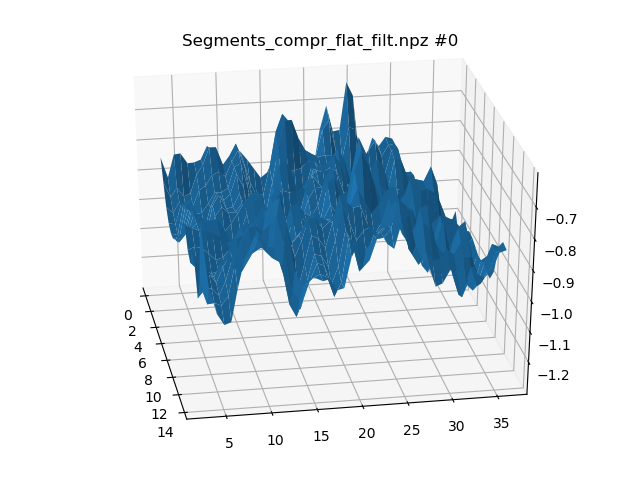

std dev of height =  0.09526635853887408
integral =  0.003851706036745407


<IPython.core.display.Javascript object>


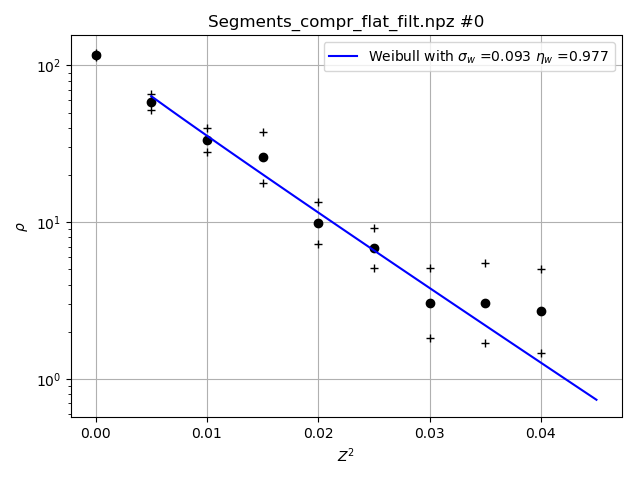

[112.75066148  51.71744802  28.15879835  17.85328072   7.22438363
   5.08514021   1.83361453   1.70216787   1.47327735]
Original =  817
4 0 205 [93 41 19 20 12  7  2  3  3]
4 1 204 [89 45 28 13  8  3  6  4  2]
4 2 204 [85 52 27 10  5  6  3  6  4]
4 3 204 [72 47 32 25 10  8  3  2  2]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.010848907982848398
statsigma =  0.10415809129802829


<IPython.core.display.Javascript object>


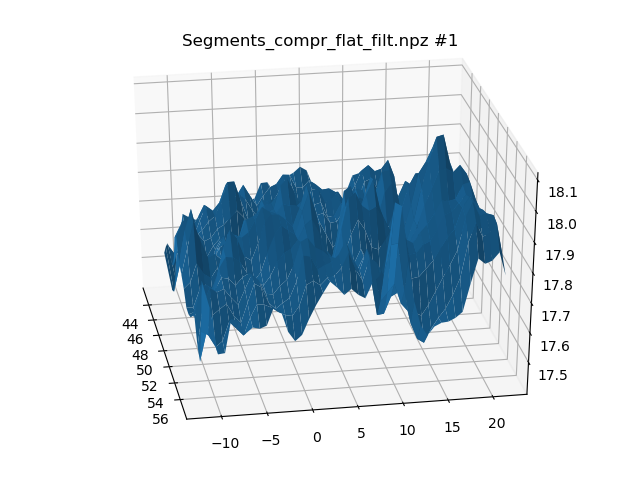

std dev of height =  0.10794878246708467
integral =  0.003902132998745295


<IPython.core.display.Javascript object>


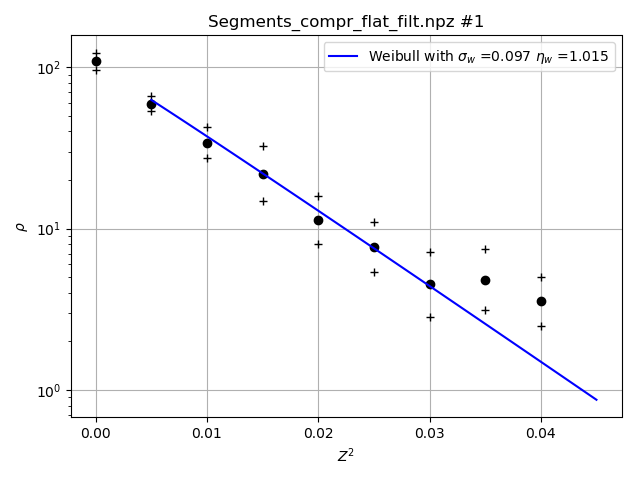

[96.53369204 53.16504538 27.33021892 14.77716279  7.97997543  5.38578214
  2.8224086   3.11669237  2.49334917]
Original =  817
4 0 205 [82 45 35 20 10  4  5  1  0]
4 1 204 [75 66 24 14 14  1  4  3  2]
4 2 204 [82 60 28 11 12  3  3  1  2]
4 3 204 [85 45 26 23 14  4  1  5  0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.009286681432173602
statsigma =  0.09636742931184583


<IPython.core.display.Javascript object>


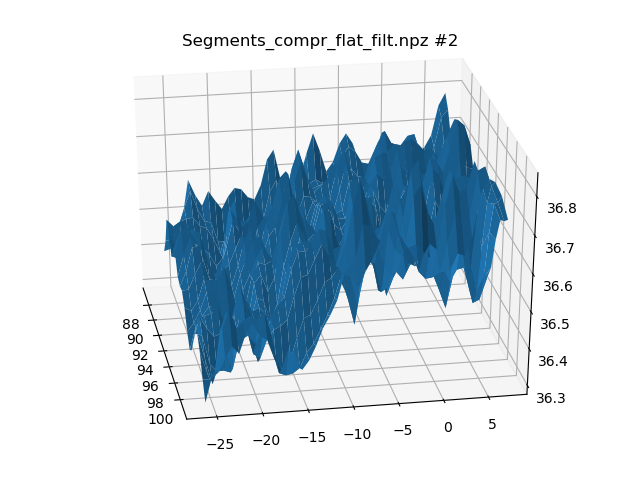

std dev of height =  0.11188432861922802
integral =  0.003987654320987654


<IPython.core.display.Javascript object>


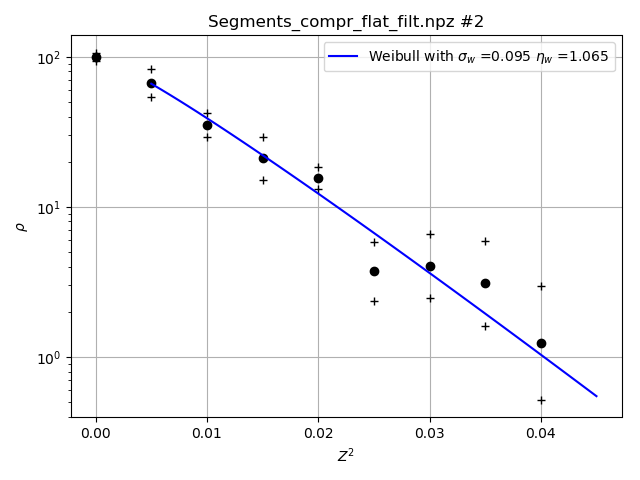

[94.36719577 54.02964926 29.0635184  15.17472906 13.07235898  2.37127507
  2.46652465  1.61177971  0.51854049]
Original =  903
4 0 226 [89 58 32 15 11  7  2  0  3]
4 1 226 [98 50 30 19  7 10  2  5  3]
4 2 226 [105  45  23  14  11  11   9   4   2]
4 3 225 [91 60 21 17 13  8  5  0  1]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.010247786295716228
statsigma =  0.10123135036003535


<IPython.core.display.Javascript object>


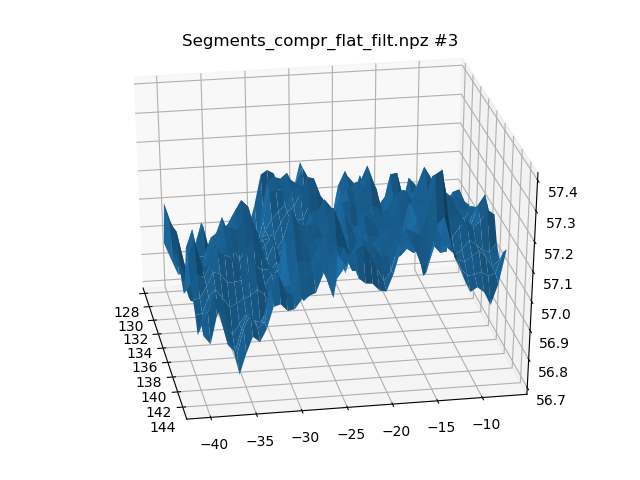

std dev of height =  0.11757605487575294
integral =  0.0038876276958002267


<IPython.core.display.Javascript object>


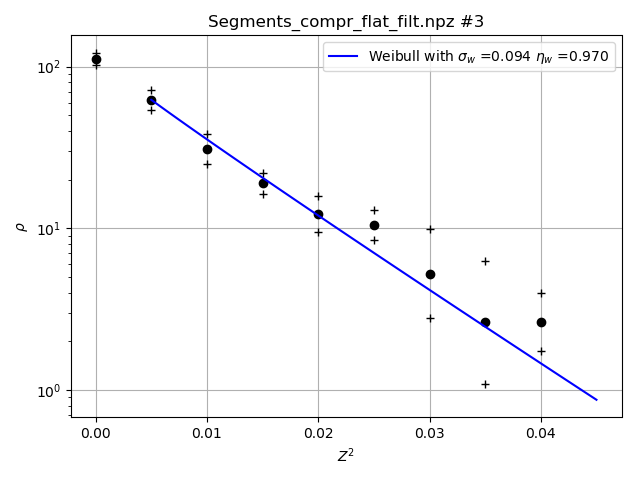

[102.46588177  53.70883541  24.92891179  16.30353494   9.51968831
   8.45009128   2.78645175   1.09249767   1.73840519]
Original =  774
4 0 194 [93 48 20 14  8  4  1  3  1]
4 1 194 [104  40  27  11   3   3   1   2   0]
4 2 193 [93 46 29  6  9  5  1  1  0]
4 3 193 [91 51 24 10  7  4  2  3  0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.007916219514902132
statsigma =  0.08897313928878835


<IPython.core.display.Javascript object>


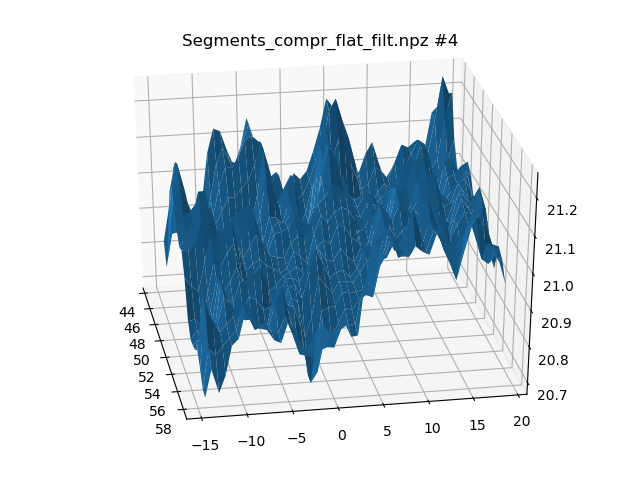

std dev of height =  0.0951054054508282
integral =  0.0037516339869281047


<IPython.core.display.Javascript object>


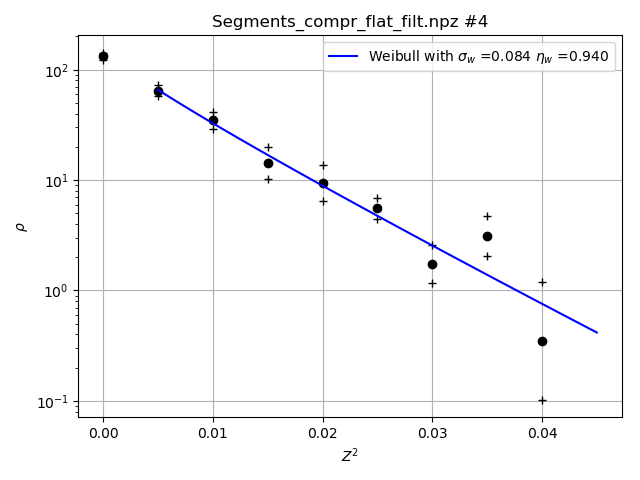

[1.23538699e+02 5.75142797e+01 2.93217039e+01 1.02957509e+01
 6.40666347e+00 4.47638409e+00 1.17642438e+00 2.07457762e+00
 1.02345402e-01]
Original =  774
4 0 194 [70 37 24 27 11 11  3  6  1]
4 1 194 [73 36 33 19  9 12  1  3  2]
4 2 193 [59 45 32 24 13  8  3  2  2]
4 3 193 [64 42 27 25 13  8  2  4  2]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.012290005111572454
statsigma =  0.11086029546944413


<IPython.core.display.Javascript object>


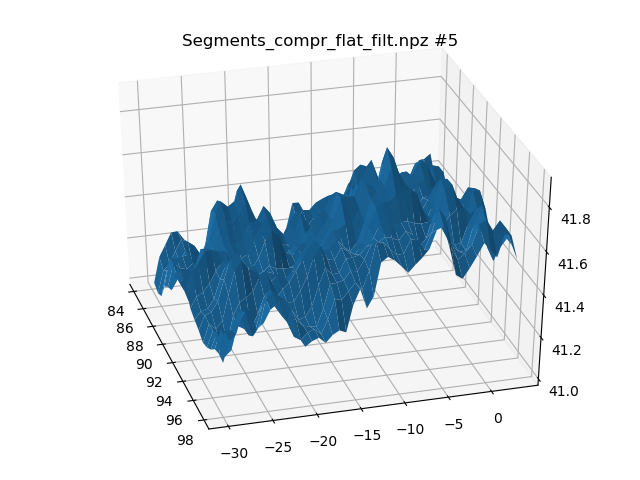

std dev of height =  0.16142090638410028
integral =  0.004093625498007968


<IPython.core.display.Javascript object>


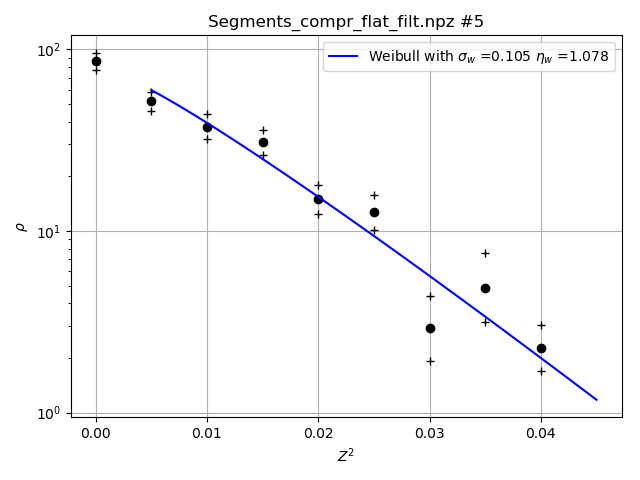

[77.53927844 46.03562419 32.00296204 26.28984252 12.43389534 10.08774065
  1.93156132  3.14449741  1.69027971]
Original =  731
4 0 183 [53 36 25 20 12  7  5  7  4]
4 1 183 [49 37 28 21  9 13  1  5  2]
4 2 183 [50 37 25 20 11  9  9  3  2]
4 3 182 [48 37 27 17 16  7  6  8  5]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.016873849421656525
statsigma =  0.12989938191406658
Original =  902
4 0 226 [69 59 20 22 10 10  4  5  6]
4 1 226 [68 53 26 21 15 12  8  6  4]
4 2 225 [72 41 29 26  8  9  9  9  5]
4 3 225 [64 52 28 22 19  9 10  5  4]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.016070325166688427
statsigma =  0.126768786247595
Original =  774
4 0 194 [77 40 20 19 14  5 10  4  3]
4 1 194 [85 34 31 19 10  6  3  2  1]
4 2 193 [73 34 21 22 18 12  5  4  0]
4 3 193 [65 56 27 12 13  6  6  2  0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.011200478941085024
statsigma =  0.10583231520232855
Original =  817
4 0 205 [46 35 21 28 16 14 10  6  6]
4 1 204 [53 37 2

In [40]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)
    
    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Graph the surface
        fig1 = plt.figure()
        ax = fig1.add_subplot(111, projection='3d')
        ax.plot_surface(xgrid, ygrid, sollast)
        title = Flattenedfilename+' #'+str(isegment)
        ax.set_title(title)
        ax.view_init(30, -10)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # Graph the probability
        plt.figure()
        plt.semilogy(bins, counts, 'ok')
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)
        plt.semilogy(bins, countsplus, '+k')
        plt.semilogy(bins, countsminus,'+k')
        plt.title(title)
        plt.xlabel(r'$Z^{2}$')
        plt.ylabel(r'$\rho$')
        plt.grid(True)
        
        # Attempt a best-fit
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])
        analysis = weibull.Analysis(Z2flat_new)
        analysis.fit(method='mle')
        etaW = analysis.beta
        sigma2W = analysis.eta
        sigmaW = np.sqrt(sigma2W)
        
        # Graph the best-fit probability
        myWeibull = Weibull(Z2theory,sigma2W,etaW)
        plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
        plt.legend()
        
    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

Original =  1014
4 0 254 [105  68  31  22   7  10   4   6   0]
4 1 254 [115  58  32  20  13   7   4   2   1]
4 2 253 [109  64  34  16  13   9   3   2   2]
4 3 253 [115  71  34  10   7   5   7   1   0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.008817638379610398
statsigma =  0.09390228101388377
integral =  0.0038902681231380337
eta_W =  0.9982078142157381
sigma_W =  0.09519716096321423


<IPython.core.display.Javascript object>


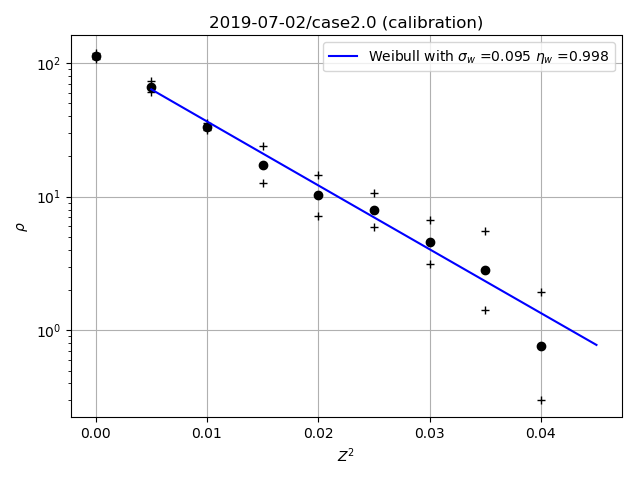

[107.62684023  60.3727008   31.69446208  12.63122863   7.20849492
   5.8879266    3.14120377   1.42578803   0.30211982]


In [41]:
# Sum up the accumulated informaion
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
ikeep = np.argwhere(Z2flat_total < Z2maxforhist)
Z2flat_new = np.squeeze(Z2flat_total[ikeep])

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho

# Get the best Weibull parameters
analysis = weibull.Analysis(Z2flat_new)
analysis.fit(method='mle')
etaW = analysis.beta; print ('eta_W = ',etaW)
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W); print ('sigma_W = ',sigmaW)

# Graph the probability
plt.figure()
plt.semilogy(bins, counts, 'ok')
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
plt.legend()

In [42]:
plt.savefig(Roughnessfilename)